In [17]:
import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import yaml
from icecream import ic

from bandit_sim.configs import AlgorithmConfig, BanditEnvConfig
from bandit_sim.setting import Settings, generate_base_filename

In [18]:
result_dir = "20250818-2324-alignment"
output_dir = os.path.join("../output/", result_dir)

config = {}

with open(os.path.join(output_dir, "simulation_config.yaml"), "r") as config_file:
    raw_dict = yaml.full_load(config_file)  # TODO: Make config loadable.
    for k, v in raw_dict.items():
        if k == "bandit_env_config":
            config_value = BanditEnvConfig.model_validate(v)
        elif k == "algorithm_configs":
            config_value = [AlgorithmConfig.model_validate(alg_dict) for alg_dict in v]
        elif k == "settings":
            config_value = Settings(**v)
        else:
            config_value = v

        config[k] = config_value

settings: Settings = config["settings"]
algorithms: list[AlgorithmConfig] = config["algorithm_configs"]
bandit_env_config = config["bandit_env_config"]
bandit_env_name = config["bandit_env_name"]

# config
T = settings.T
trials = settings.num_trials
K = settings.num_arms
base_seed = settings.base_seed

num_trials = settings.num_trials
trial_id_overrides = settings.trial_id_overrides

if trial_id_overrides is not None and len(trial_id_overrides) > 0:
    trial_ids = trial_id_overrides
    num_trials = len(trial_ids)
else:
    trial_ids = range(num_trials)

num_algs = len(algorithms)
K_env = K // 2

In [19]:
bandit_env_params = None
filename = generate_base_filename(base_seed)

with open(os.path.join(output_dir, f"bandit_env_params_{filename}"), "rb") as f:
    bandit_env_params = np.load(f)

ic(bandit_env_params.shape)
ic(bandit_env_params)

ic| bandit_env_params.shape: (1, 16, 2)
ic| bandit_env_params: array([[[0.78051542, 0.81335557],
                               [0.58111215, 0.62444765],
                               [0.63219975, 0.66068529],
                               [0.74060568, 0.5915099 ],
                               [0.14571035, 0.25426824],
                               [0.20242822, 0.31772629],
                               [0.82297591, 0.30704928],
                               [0.00946648, 0.65980196],
                               [0.19267431, 0.88360156],
                               [0.16854135, 0.58016893],
                               [0.15936197, 0.33265574],
                               [0.44575114, 0.15083988],
                               [0.79811342, 0.09145049],
                               [0.85226899, 0.43641727],
                               [0.27872961, 0.53770218],
                               [0.22205428, 0.38133372]]])


array([[[0.78051542, 0.81335557],
        [0.58111215, 0.62444765],
        [0.63219975, 0.66068529],
        [0.74060568, 0.5915099 ],
        [0.14571035, 0.25426824],
        [0.20242822, 0.31772629],
        [0.82297591, 0.30704928],
        [0.00946648, 0.65980196],
        [0.19267431, 0.88360156],
        [0.16854135, 0.58016893],
        [0.15936197, 0.33265574],
        [0.44575114, 0.15083988],
        [0.79811342, 0.09145049],
        [0.85226899, 0.43641727],
        [0.27872961, 0.53770218],
        [0.22205428, 0.38133372]]])

```
array([[[0.55816467, 0.64956509],
        [0.3924774 , 0.15434337],
        [0.52445407, 0.12741056],
        [0.76878136, 0.66354573],
        [0.52746323, 0.00325044],
        [0.70904825, 0.89618992],
        [0.1866809 , 0.22438431],
        [0.62856906, 0.97795175],
        [0.72141581, 0.67531868],
        [0.84310354, 0.10980487],
        [0.52261935, 0.8465304 ],
        [0.630737  , 0.71617729],
        [0.8527067 , 0.38089709],
        [0.51195239, 0.02751231],
        [0.40319264, 0.49528798],
        [0.72736088, 0.13100071]]])
```

In [20]:
raw_df = pl.DataFrame()

for i, trial_id in enumerate(trial_ids):
    filename = generate_base_filename(base_seed, trial_id)
    with open(os.path.join(output_dir, f"data_{filename}"), "rb") as f:
        raw_df.vstack(pl.read_parquet(f), in_place=True)

raw_df

reward,action,info_ratio,r_star,argmin,not_optimal,algorithm,time_step,regret,trial
f64,u8,f64,f64,bool,bool,cat,u32,f64,u16
0.375552,1,0.478114,0.803885,false,false,"""IDS""",0,0.30025,7
0.84916,11,0.48021,0.804551,false,false,"""IDS""",1,0.126892,7
0.332656,10,0.481178,0.804858,false,false,"""IDS""",2,0.470038,7
0.59151,3,0.48245,0.80526,false,false,"""IDS""",3,0.55433,7
0.813356,0,0.482343,0.805226,false,false,"""IDS""",4,0.416777,7
…,…,…,…,…,…,…,…,…,…
0.682274,5,33.65734,0.795449,true,null,"""IDS argmin""",9995,1491.183368,7
0.682274,5,33.612027,0.795416,true,null,"""IDS argmin""",9996,1491.176896,7
0.682274,5,33.576016,0.795397,true,null,"""IDS argmin""",9997,1491.170425,7


In [21]:
aggregated_df = (
    raw_df.group_by("algorithm", "time_step")
    .agg(
        pl.col("regret").mean().alias("regret mean"),
        pl.col("regret").std().alias("regret std"),
        pl.col("info_ratio").mean().alias("info ratio mean"),
        pl.col("info_ratio").std().alias("info ratio std"),
    )
    .sort("time_step")
)

grouped_df = aggregated_df.group_by("algorithm")

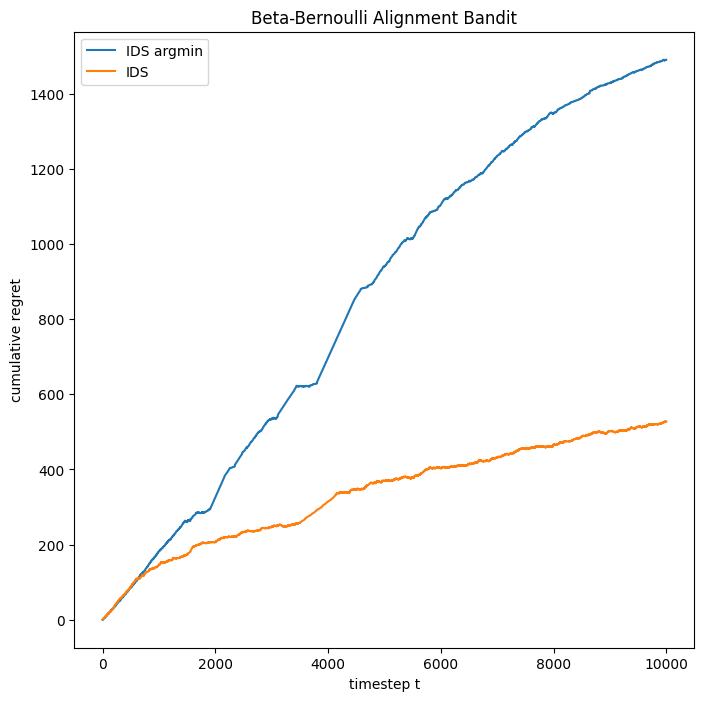

In [22]:
"""
Section below is for plotting
"""
title = bandit_env_name
output = bandit_env_config.label

plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

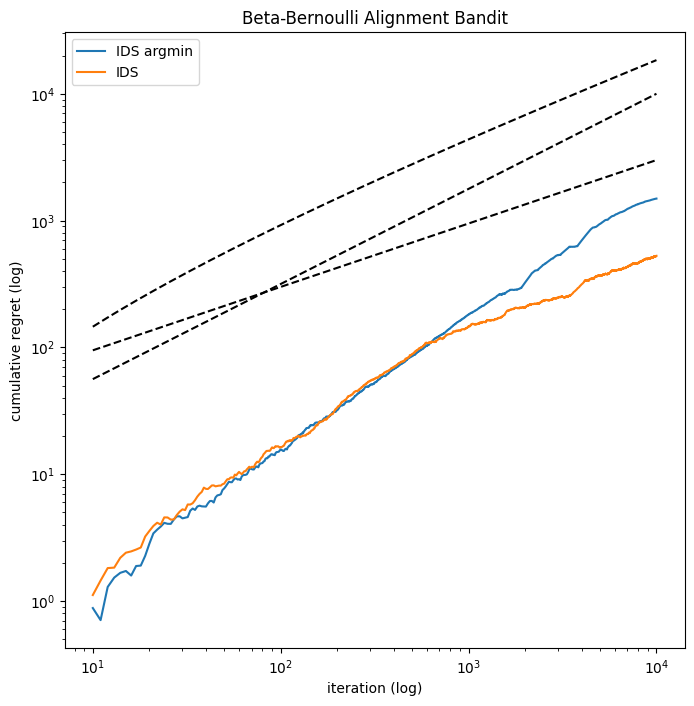

In [23]:
# log log plot
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["regret mean"]
    stds = data["regret std"]
    plt.plot(
        np.arange(10, T),
        means[10:],
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means[10:] + stds[10:],
        means[10:] - stds[10:],
        alpha=0.3,
    )
# lines for comparison
x = np.arange(10, T)
sqrt_x = 30 * np.sqrt(x)
sqrt_x_log_x = 20 * np.sqrt(x) * np.log(x)
x_3_4 = 10 * x ** (3 / 4)

# plt.plot(x, x, "k--")
plt.plot(x, sqrt_x, "k--")
plt.plot(x, sqrt_x_log_x, "k--")
plt.plot(x, x_3_4, "k--")
# plt.xlim(left=0, right=T)
# plt.ylim(bottom=0, top=120)
plt.title(title)
plt.xlabel("iteration (log)")
plt.ylabel("cumulative regret (log)")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

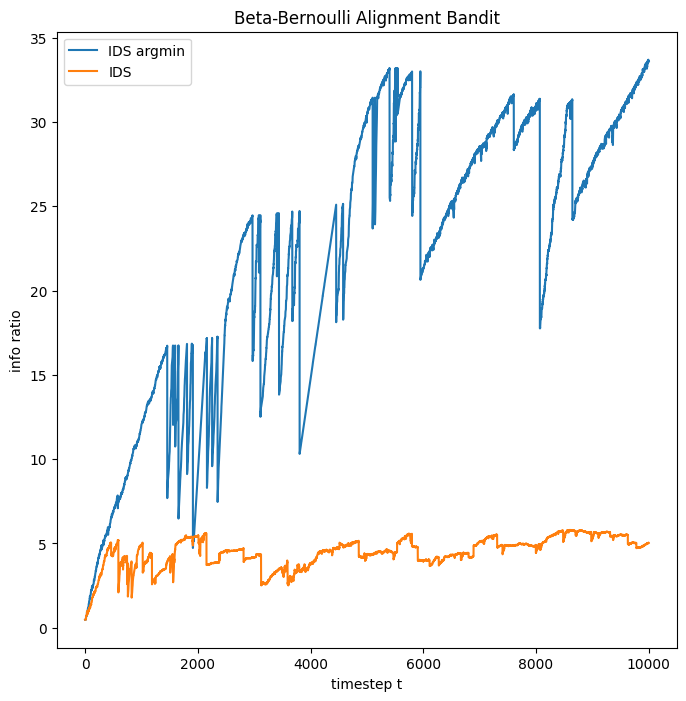

In [24]:
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["info ratio mean"]
    stds = data["info ratio std"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("info ratio")
plt.legend()
plt.show()

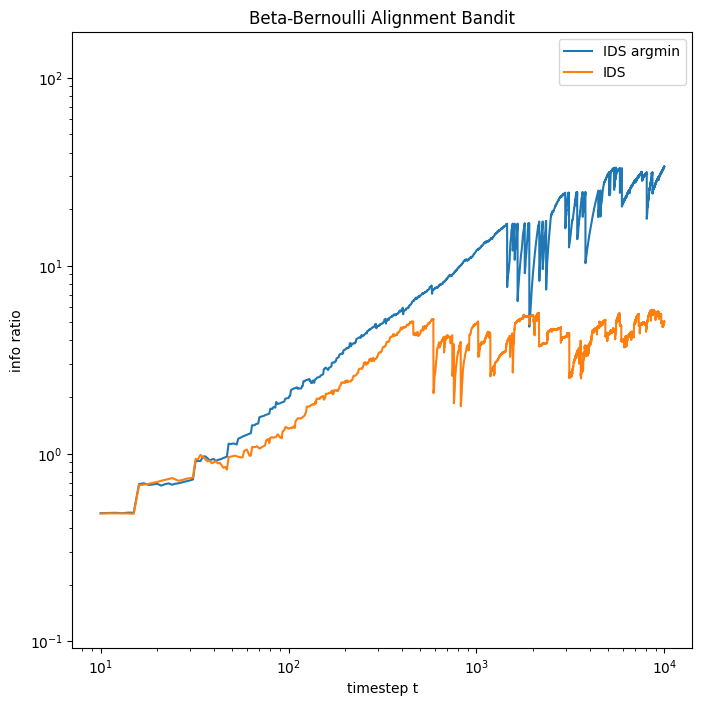

In [25]:
plt.figure(figsize=(8, 8))

for alg_name, data in grouped_df:
    means = data["info ratio mean"][10:]
    stds = data["info ratio std"][10:]
    plt.plot(
        np.arange(10, T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("info ratio")
plt.legend()
plt.show()

In [26]:
df_human_actions = (
    raw_df.with_columns(
        pl.when(pl.col("action") < K_env)
        .then(pl.lit(0))
        .otherwise(pl.lit(1))
        .alias("human action")
    )
    .with_columns(
        pl.col("human action")
        .cum_sum()
        .over("algorithm", "trial", order_by="time_step")
        .alias("cumulative human action")
    )
    .group_by("algorithm", "time_step")
    .agg(
        pl.col("cumulative human action").mean().alias("mean cum human action"),
        pl.col("cumulative human action").std().alias("std cum human action"),
    )
    .sort("time_step")
)

df_human_actions_grouped = df_human_actions.group_by("algorithm")

df_human_actions

algorithm,time_step,mean cum human action,std cum human action
cat,u32,f64,f64
"""IDS""",0,0.0,null
"""IDS argmin""",0,0.0,null
"""IDS""",1,0.0,null
"""IDS argmin""",1,0.0,null
"""IDS""",2,0.0,null
…,…,…,…
"""IDS argmin""",9997,48.0,null
"""IDS""",9998,141.0,null
"""IDS argmin""",9998,48.0,null


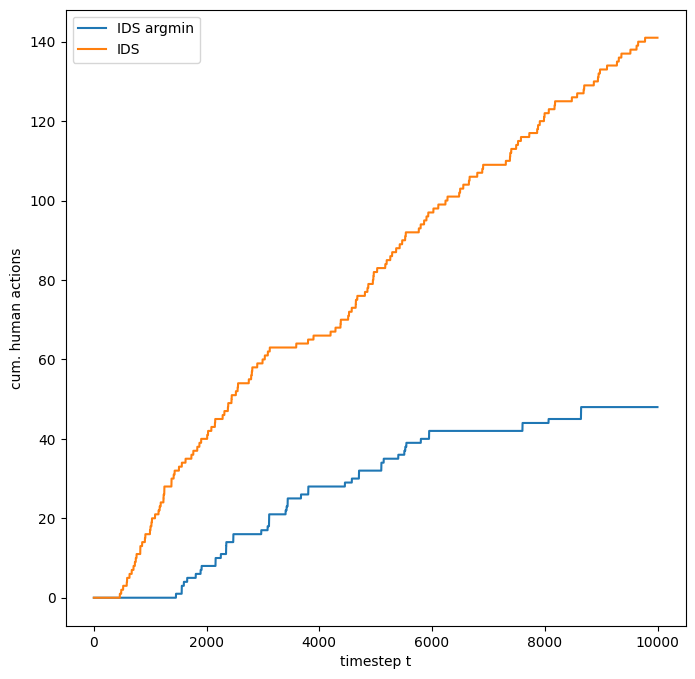

In [27]:
plt.figure(figsize=(8, 8))

for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"]
    stds = data["std cum human action"]
    plt.plot(
        np.arange(T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

plt.xlabel("timestep t")
plt.ylabel("cum. human actions")
plt.legend()
plt.show()

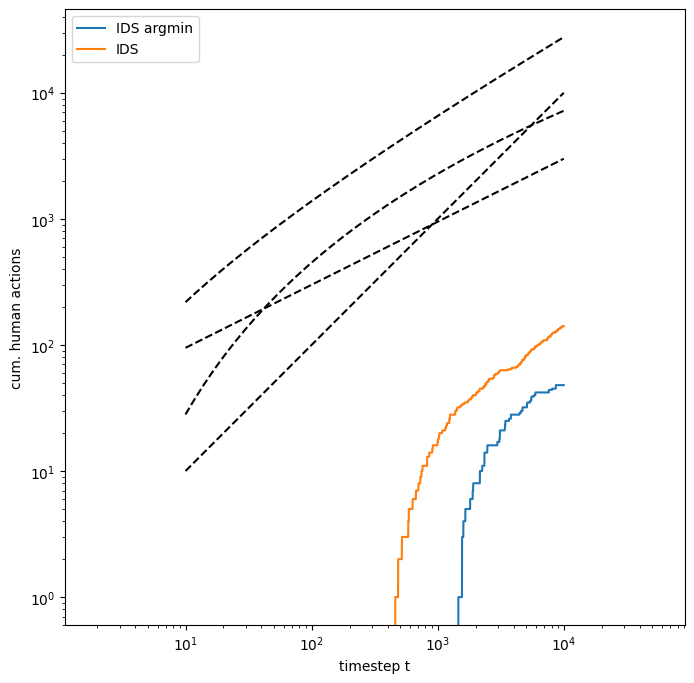

In [28]:
plt.figure(figsize=(8, 8))
for alg_name, data in df_human_actions_grouped:
    means = data["mean cum human action"][10:]
    stds = data["std cum human action"][10:]
    plt.plot(
        np.arange(10, T),
        means,
        label=alg_name,
    )
    plt.fill_between(
        np.arange(10, T),
        means + stds,
        means - stds,
        alpha=0.3,
    )

sqrt_t = np.sqrt(np.arange(10, T))
sqrt_t_log_t = np.sqrt(np.arange(10, T)) * np.log(np.arange(10, T))
log_t = np.log(np.arange(10, T)) * np.log(np.arange(10, T))

plt.plot(np.arange(10, T), np.arange(10, T), color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t_log_t, color="black", linestyle="--")
plt.plot(np.arange(10, T), log_t**2, color="black", linestyle="--")
plt.plot(np.arange(10, T), 30 * sqrt_t, color="black", linestyle="--")

plt.xscale("log")
plt.yscale("log")
plt.axis("equal")

plt.xlabel("timestep t")
plt.ylabel("cum. human actions")
plt.legend()
plt.show()

Let's identify one problematic seed

In [29]:
temp_df = (
    raw_df.filter(
        pl.col("algorithm") == "IDS",
    )
    .select("trial", "regret", "r_star", "time_step")
    .group_by("trial")
)

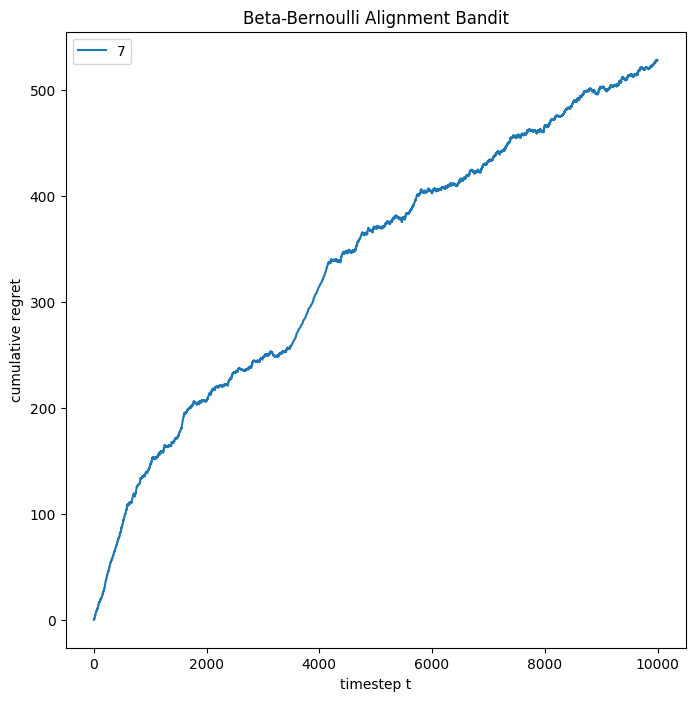

In [30]:
plt.figure(figsize=(8, 8))

# sqrt_t = np.sqrt(np.arange(10, T))
# sqrt_t_log_t = np.sqrt(np.arange(10, T)) * np.log(np.arange(10, T))
# log_t = np.log(np.arange(10, T)) * np.log(np.arange(10, T))

# plt.plot(np.arange(10, T), np.arange(10, T), color="black", linestyle="--")
# plt.plot(np.arange(10, T), 30 * sqrt_t_log_t, color="black", linestyle="--")
# plt.plot(np.arange(10, T), log_t**2, color="black", linestyle="--")
# plt.plot(np.arange(10, T), 30 * sqrt_t, color="black", linestyle="--")

for trial, data in temp_df:
    plt.plot(
        np.arange(T),
        data["regret"],
        label=trial,
    )

# plt.xscale("log")
# plt.yscale("log")
# plt.axis("equal")

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("cumulative regret")
plt.legend()
plt.show()

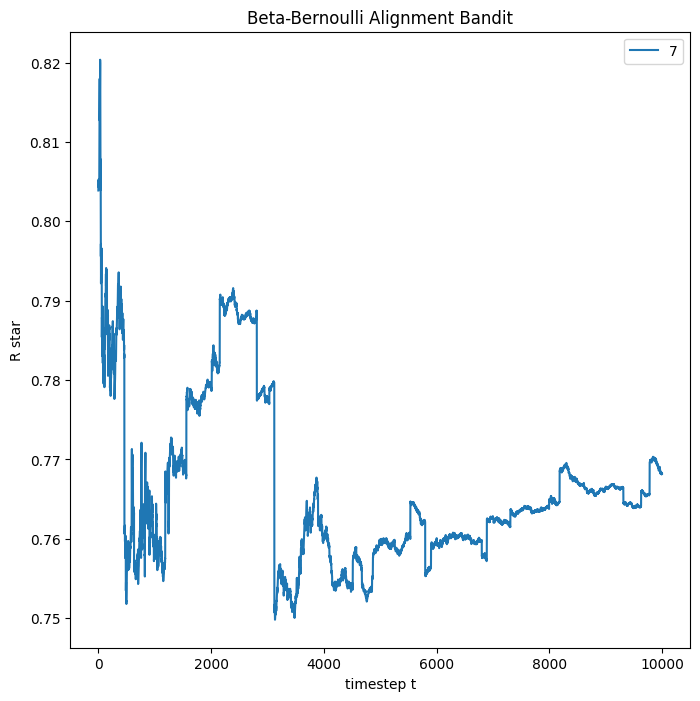

In [31]:
plt.figure(figsize=(8, 8))

for trial, data in temp_df:
    plt.plot(
        np.arange(T),
        data["r_star"],
        label=trial,
    )

plt.title(title)
plt.xlabel("timestep t")
plt.ylabel("R star")
plt.legend()
plt.show()

In [16]:
phis = bandit_env_params[0, :, 0]
thetas = bandit_env_params[0, :, 1]

true_reward_means = phis * thetas + (1 - phis) * (1 - thetas)
ic(true_reward_means)

ic| true_reward_means: array([0.67580214, 0.52018843, 0.54248511, 0.5440356 , 0.67412044,
                              0.60847903, 0.37536313, 0.34322356, 0.26421878, 0.44685463,
                              0.61400764, 0.53788308, 0.25641181, 0.45520355, 0.48331525,
                              0.56596557])


array([0.67580214, 0.52018843, 0.54248511, 0.5440356 , 0.67412044,
       0.60847903, 0.37536313, 0.34322356, 0.26421878, 0.44685463,
       0.61400764, 0.53788308, 0.25641181, 0.45520355, 0.48331525,
       0.56596557])